In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

### Data Loading

In [3]:
main_file = pd.read_csv('data/DDI_data.csv',delimiter=',')
merged_file = pd.read_excel('data/DDI_types_merged.xlsx')
type_file = pd.read_excel('data/DDI_types.xlsx')

In [4]:
main_file.head()
main_file['interaction_type'].isna().sum()

0

In [5]:
type_file.head()


,Order,Origin DDI's type,merged DDI type index
0,1,"'metabolism',",8
1,2,"'serum concentration',",2
2,3,"'risk or severity of bleeding',",7
3,4,"'anticoagulant activities',",20
4,5,"'risk or severity of adverse effects',",7


In [6]:
merged_file.head()

,merged DDI type index,type name,count,color
0,1,QTc-prolonging activities,6300,"254, 203, 82"
1,2,serum concentration and absorption,41066,"182, 232, 128"
2,3,neural activity,1885,"198, 202, 253"
3,4,stimulatory activities,418,"255, 233, 183"
4,5,hyperglycemic and hyponatremic activities,2442,"0, 204, 150"


In [7]:
print(merged_file.columns)

Index(['merged DDI type index', 'type name ', 'count', 'color'], dtype='object')


### Preprocessing

In [8]:
# Merging interaction types index using other files 

#Cleaning columns
main_file.columns = main_file.columns.str.strip()
type_file.columns = type_file.columns.str.strip()
merged_file.columns = merged_file.columns.str.strip()

#Extracting relation
interaction_map = {}
for _,row in type_file.iterrows():
    merged_index = row['merged DDI type index']
    raw_types = str(row["Origin DDI's type"])

    for t in pd.Series(raw_types.split(',')):
        t_clean = t.strip().replace("'","").lower()
        if t_clean:
            interaction_map[t_clean] = merged_index

# Mapping Relation
def get_merged_index(interaction_str):
    if pd.isna(interaction_str):
        return None
    
    for part in interaction_str.split(','):
        part_clean = part.strip().lower()
        if part_clean in interaction_map:
            return interaction_map[part_clean]
        

main_file['interaction_type_clean'] = main_file['interaction_type'].str.strip().str.lower() 
main_file['merged DDI type index'] = main_file['interaction_type'].apply(get_merged_index)

print(main_file['merged DDI type index'].isna().sum())

#Endcoding the drugs name to int values
drugs_names = pd.concat([main_file['drug1_id'],main_file['drug2_id']])
le = LabelEncoder()
out = le.fit(drugs_names)

main_file['drug1id_num'] = le.transform(main_file['drug1_id'])
main_file['drug2id_num'] = le.transform(main_file['drug2_id'])


final_cols = [
    'drug1_id',
    'drug2_id',
    'drug1_name',
    'drug2_name',
    'interaction_type_clean',
    'drug1id_num',
    'drug2id_num',
    'merged DDI type index'
]

final_data = main_file[final_cols]
final_data.to_csv("label_encoded.csv",index=False)
# print('Done')   

0


In [9]:
final_data.head()

,drug1_id,drug2_id,drug1_name,drug2_name,interaction_type_clean,drug1id_num,drug2id_num,merged DDI type index
0,DB00006,DB00346,Bivalirudin,Alfuzosin,serum concentration,0,186,2
1,DB00006,DB13783,Bivalirudin,Acemetacin,risk or severity of bleeding,0,1835,7
2,DB00006,DB06605,Bivalirudin,Apixaban,anticoagulant activities,0,1337,20
3,DB00006,DB06695,Bivalirudin,Dabigatran etexilate,anticoagulant activities,0,1350,20
4,DB00006,DB09075,Bivalirudin,Edoxaban,anticoagulant activities,0,1555,20


### EDA

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

1. Networking Graph

In [13]:
top_drugs = pd.concat([final_data['drug1id_num'],final_data['drug2id_num']]).value_counts().head(25).index
df_top = final_data[final_data['drug1id_num'].isin(top_drugs) & final_data['drug2id_num'].isin(top_drugs)]

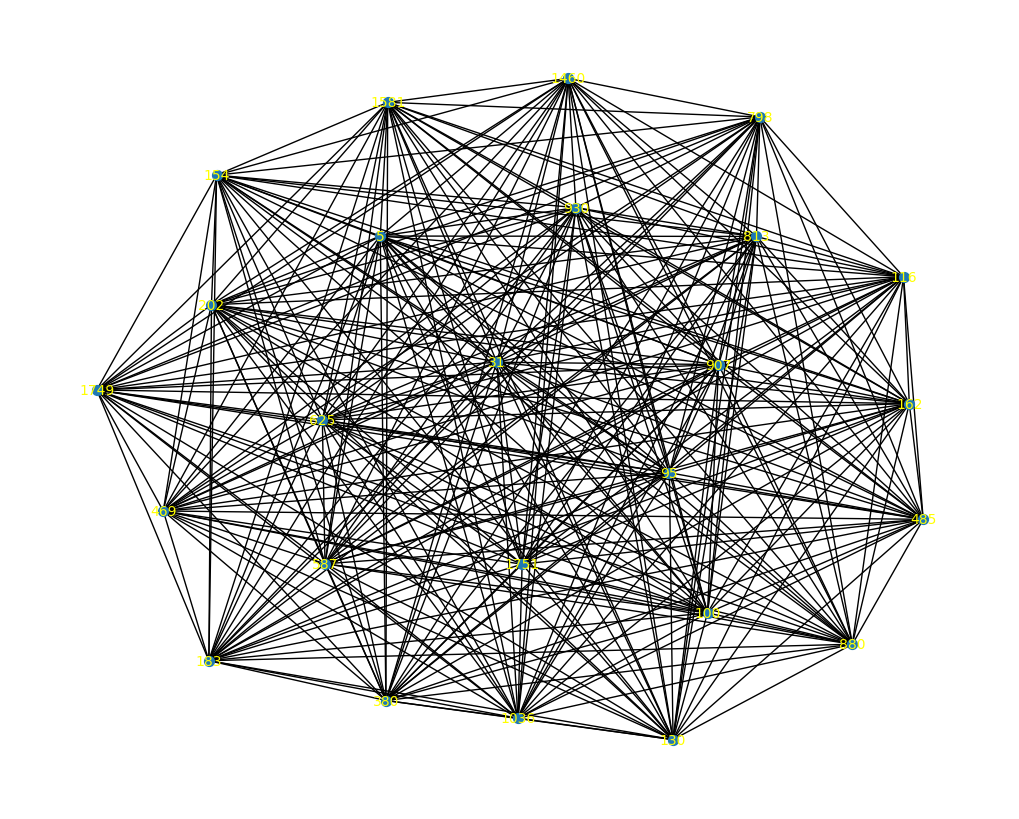

In [14]:
G = nx.from_pandas_edgelist(df_top,'drug1id_num','drug2id_num',edge_attr='merged DDI type index')
plt.figure(figsize=(10,8))
nx.draw(G,node_size=50,with_labels=True,font_size=10,font_color='yellow')
plt.show()

2. Interaction type frequency graph

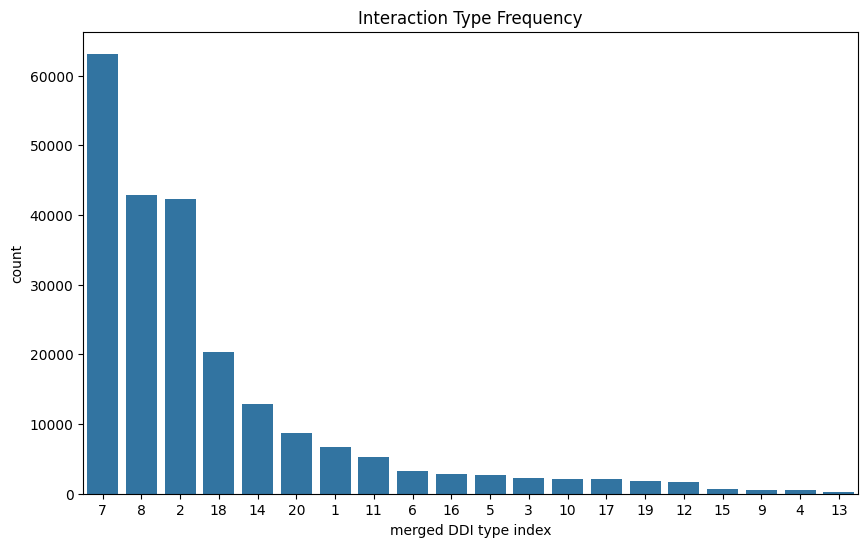

In [15]:
plt.figure(figsize=(10,6))
sns.countplot(x='merged DDI type index', data=final_data, order=final_data['merged DDI type index'].value_counts().index)
plt.title("Interaction Type Frequency")
plt.show()

3. Most common drugs

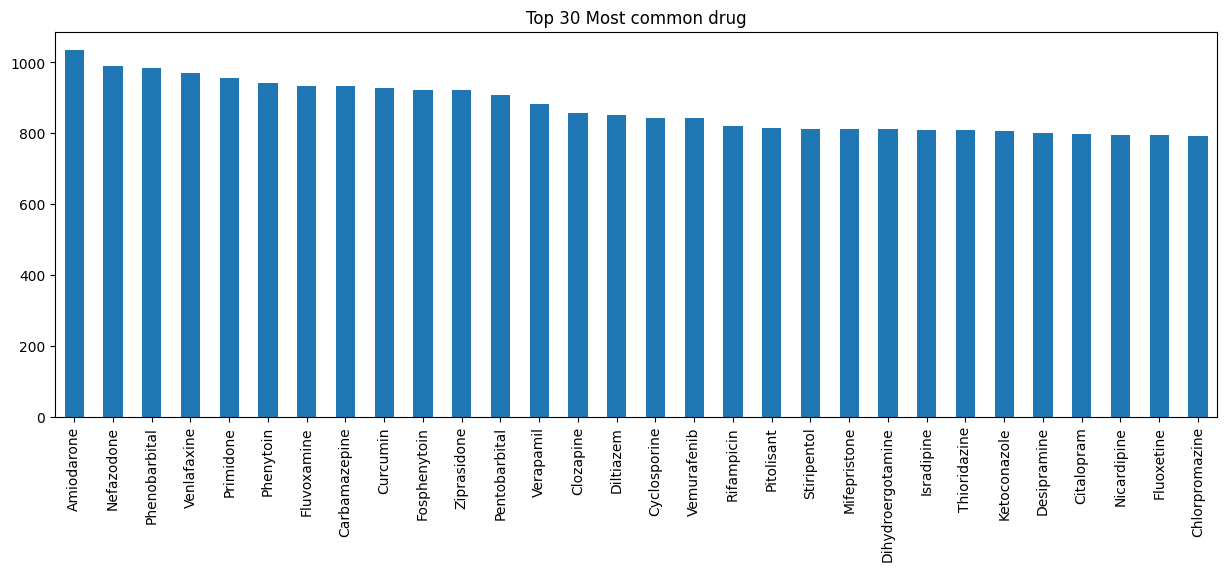

In [16]:
#Both columns combination to see freq
all_drugs = pd.concat([final_data['drug1_name'],final_data['drug2_name']])
drugs_names = all_drugs.value_counts()

plt.figure(figsize=(15,5))
drugs_names.head(30).plot(kind='bar')
plt.title('Top 30 Most common drug')
plt.show()

### Model Building

Word2Vec 

In [17]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score , classification_report
from gensim.models import Word2Vec
import xgboost as xgb


In [18]:
sentence = final_data[['drug1_name', 'drug2_name']].values.tolist()

w2v = Word2Vec(
    sentences=sentence,
    vector_size=100,
    window=2,
    min_count=1,
    sg=1,
    workers=4,
    epochs=70
)

w2v.save('W2Vec_model.model')

In [ ]:
def pair_to_vec(drug1,drug2):
    vec1 = w2v.wv[drug1]
    vec2 = w2v.wv[drug2]

    conc = np.concatenate([vec1,vec2])
    #Feature engineering
    diff_vec = np.abs(vec1-vec2)
    multi_vec = vec2*vec1

    return np.concatenate([conc,diff_vec,multi_vec])

X = np.array([pair_to_vec(d1,d2) for d1,d2 in zip(final_data['drug1_name'],final_data['drug2_name'])])
y = final_data['merged DDI type index'].values  

print(X.shape)
print(y.shape)

group_by = np.minimum(final_data['drug1id_num'],final_data['drug2id_num'])
gkf = GroupKFold(n_splits=5)

for train_idx, val_idx in gkf.split(X,y,groups=group_by):
    X_train , X_val = X[train_idx],X[val_idx]
    y_train , y_val = y[train_idx],y[val_idx]
    break

(222696, 400)
(222696,)


##### EDA train test split


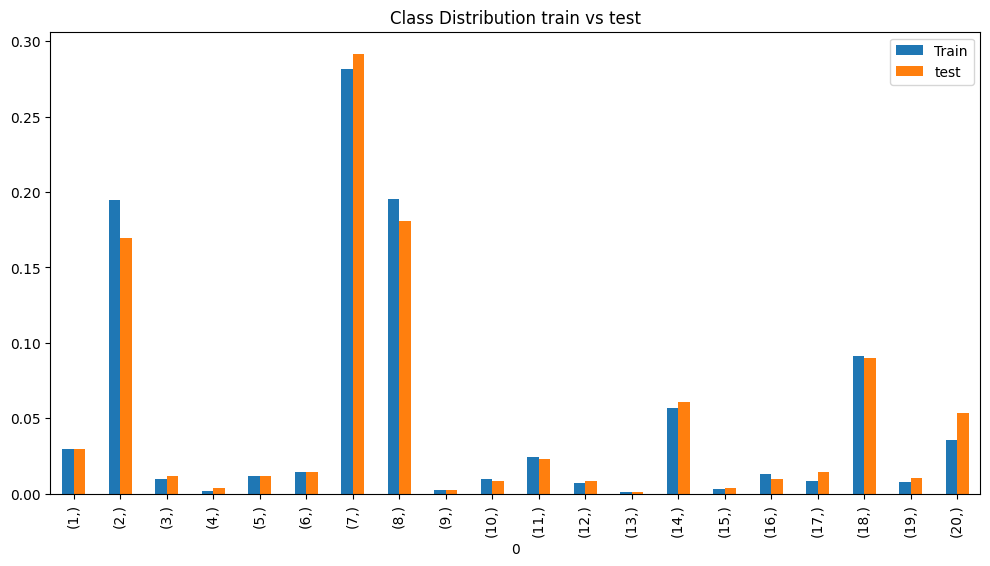

In [ ]:
train_classes = pd.DataFrame(y_train).value_counts(normalize=True)
test_classes = pd.DataFrame(y_val).value_counts(normalize=True)

pd.DataFrame({'Train':train_classes,'test':test_classes}).plot(kind='bar',figsize=(12,6))
plt.title('Class Distribution train vs test')
plt.show()

##### XGBoost


In [33]:
xgb_train = xgb.DMatrix(X_train,label=y_train,enable_categorical=True)
xgb_test = xgb.DMatrix(X_val,label=y_val,enable_categorical=True)


In [45]:
params = {
  "objective": "multi:softprob",
  "num_class": 21,
  "tree_method": "hist",
  "device": "cuda",         
  "max_depth": 5,
  "learning_rate": 0.14072201680351015,
  'subsample': 0.8833789338035989,
  "colsample_bytree": 0.8266933443142936,
  "reg_lambda": 4.34047999304056,
  'reg_alpha': 5.181890071679362,
  "min_child_weight": 7,
  "eval_metric": "mlogloss"
}
# Early stopping: 50 rounds on a validation set
model_xgb = xgb.train(params,xgb_train,num_boost_round=2500,evals=[(xgb_test,'val')],early_stopping_rounds=50,verbose_eval=False)


In [47]:
import joblib

model = joblib.dump(model_xgb,'xgb_model.pkl')

In [46]:
# Predictions for accuracy
train_preds = model_xgb.predict(xgb_train)
y_pred_train = train_preds.argmax(axis=1)

val_preds = model_xgb.predict(xgb_test)
y_pred_val = val_preds.argmax(axis=1)

train_acc = accuracy_score(y_train, y_pred_train)
val_acc = accuracy_score(y_val, y_pred_val)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

Training Accuracy: 0.9980
Validation Accuracy: 0.8605


#### Parameter selection method for Xgb model (Aditional)

1. Used optuna trial method for hyperparameter tuning 

In [ ]:
import optuna

def objective(trial):
    params = {
        "objective": "multi:softprob",
        "num_class": 21,
        "tree_method": "hist",      
        "device": "cuda",           
        "eval_metric": "mlogloss",
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 15),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 15.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 15.0),
    }
    acc_scores = []

    bst = xgb.train(
        params,
        xgb_train,
        num_boost_round=1600,
        evals=[(xgb_test, "val")],
        early_stopping_rounds=100,
        verbose_eval=False
    )

    y_pred = np.argmax(bst.predict(xgb_test), axis=1)
    acc_scores.append(accuracy_score(y_val, y_pred))

    return np.mean(acc_scores)

# ===== 3. Run Optuna study =====
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)  # try 30 trials for now

print("Best params:", study.best_params)
print("Best accuracy:", study.best_value)

# View all trial results in DataFrame
df = study.trials_dataframe()
print(df)

# (Optional) Save results for later analysis
df.to_csv("optuna_trials_results.csv", index=False)
